# Classification d'imageries motrices

In [32]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Dropout, Dense, Flatten
from tensorflow.keras.layers import MaxPooling1D, LSTM,  GRU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.stats.mstats import winsorize
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import random

## Initialisation du *data set*

### Chargement et formatage

In [33]:
df = pd.read_csv("/kaggle/input/eeg-motor-imagery-bciciv-2a/BCICIV_2a_all_patients.csv")
df = df.dropna()
eeg_columns = df.columns[4:]
df[eeg_columns] = df[eeg_columns].apply(pd.to_numeric, errors='coerce')
df = df.dropna()
labels = df['label'].unique()

### Présentation
All rows for same patient and same epoch represent a single signal

In [34]:
print('-' * 40)
print("📖 Structure du data set 📖")
print(f"On dispose de {len(eeg_columns)} canaux d'enregistrement {eeg_columns}")
print(f"Les 4 labels permettant de classer les données sont : {labels}")
print('-' * 40)
print(df.head(10))
print('-' * 40)

----------------------------------------
📖 Structure du data set 📖
On dispose de 22 canaux d'enregistrement Index(['EEG-Fz', 'EEG-0', 'EEG-1', 'EEG-2', 'EEG-3', 'EEG-4', 'EEG-5',
       'EEG-C3', 'EEG-6', 'EEG-Cz', 'EEG-7', 'EEG-C4', 'EEG-8', 'EEG-9',
       'EEG-10', 'EEG-11', 'EEG-12', 'EEG-13', 'EEG-14', 'EEG-Pz', 'EEG-15',
       'EEG-16'],
      dtype='object')
Les 4 labels permettant de classer les données sont : ['tongue' 'foot' 'right' 'left']
----------------------------------------
   patient   time   label  epoch    EEG-Fz     EEG-0     EEG-1     EEG-2  \
0        1 -0.100  tongue      8 -1.681412  2.245496 -0.158350  1.163765   
1        1 -0.096  tongue      8  0.420417  0.587559  1.650510  0.970672   
2        1 -0.092  tongue      8  0.551365  1.499758  0.121302  2.859433   
3        1 -0.088  tongue      8  3.054916 -1.807238  1.843603  2.286812   
4        1 -0.084  tongue      8  2.506710 -2.453101  0.221178  0.127278   
5        1 -0.080  tongue      8  1.150619 -2.0

### Exploitabilité


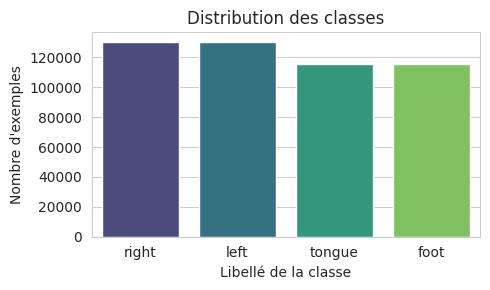

In [35]:
sns.set_style("whitegrid")
plt.figure(figsize=(5, 3))
sns.countplot(x='label', data=df, palette='viridis', order=df['label'].value_counts().index)
plt.xlabel("Libellé de la classe", fontsize=10)
plt.ylabel("Nombre d'exemples", fontsize=10)
plt.title("Distribution des classes", fontsize=12)
plt.tight_layout()
plt.show()

# Pré-traitement

## Groupement des données
Initialement, les données sont éparses ; de fait, il nous fait regrouper les amplitudes des signaux selon l'*epoch* qu'elles modélisent.

In [36]:
epochs = df.groupby('epoch')
x, y = [], []

target_length = 201

for i, epoch in epochs:
    data = epoch[eeg_columns].values.T
    if data.shape[1] > target_length:
        data = data[:, :target_length]
    elif data.shape[1] < target_length:
        pad_width = target_length - data.shape[1]
        data = np.pad(data, ((0, 0), (0, pad_width)), mode='constant')
    x.append(data)
    y.append(epoch['label'].iloc[0])
    
x = np.array(x)
y = np.array(y)
print(f"Dimension de x après regroupemment : {x.shape}")
print(f"Dimension de y après regroupemment : {y.shape}")

Dimension de x après regroupemment : (632, 22, 201)
Dimension de y après regroupemment : (632,)


## Normalisation

Pour des questions d'échelles, de stabilité, et de performance, il est nécessaire de normaliser les données. En effet :
1. L'information d'un canal à l'autre, d'une mesure à l'autre, prend place dans une plage de valeur inhérente à ceux-ci ; lesquelles pouvant notablement varier. Ici, la normalisation est vouée à prévenir toute démesure dans la place que pourrait prendre telle ou telle métrique. On s'assure de la **bonne équité de la représentation des variables ; et subséquemment, de leur influence sur le modèle**.
2. Par ailleurs, **l'apprentissage est à même de converger plus efficacement** si les données sont normalisées ; en évitant d'ailleurs les problèmes d'évanescence et d'explosion du gradient.
3. Enfin, comme toute information porte un bruit inhérent aux conditions expérimentales, ainsi qu'un variabilité naturelle ; la normalisation permet d'**éviter les problèmes de généralisations**.

Dans les expériences menées, la normalisation par z-score a démontré la plus haute précision par rapport à d'autres méthodes de normalisation telles que la normalisation logarithmique (log) et la normalisation min-max.

Avant la normalisation, les signaux de chaque électrode ont été "winsorized" pour réduire les effets des valeurs aberrantes de grande amplitude. Cela impliquait de remplacer les valeurs d'amplitude inférieures au 5ème percentile ou supérieures au 95ème percentile par ces percentiles respectifs, car la moyenne et l'écart-type sont sensibles aux valeurs aberrantes

$$S'_{ijk} = \frac{\text{winsorize}(S_{ijk}) - \mu_{ij}}{\sigma_{ij}}$$
Où :
- $S_{ijk}$ est l'amplitude brute du signal au canal ii, essai jj, temps kk
- $\text{winsorize}(S_{ijk})$ désigne le signal après winsorisation (par exemple à 5% et 95%)
- $\mu_{ij}$ est la moyenne du signal winsorisé du canal ii pour l'essai jj
- $\sigma_{ij}$ est l’écart-type correspondant

In [37]:
n_samples, n_channels, n_time_points = x.shape
x_normalized = np.zeros_like(x)

for i in range(n_samples):
    for ch in range(n_channels):
        signal = x[i, ch, :]
        signal_winsorized = winsorize(signal, limits=[0.05, 0.05])
        scaler = StandardScaler()
        x_normalized[i, ch, :] = scaler.fit_transform(signal_winsorized.reshape(-1, 1)).flatten()

Les signaux EEG sont souvent meilleurs discriminants en fréquence (ex. : tâches motrices activent certaines bandes).

Cela permet de détecter les bandes spectrales caractéristiques (delta, theta, alpha, etc.).

Ces amplitudes peuvent ensuite être utilisées comme entrées pour un modèle IA (ex. : CNN, LSTM, SVM...).

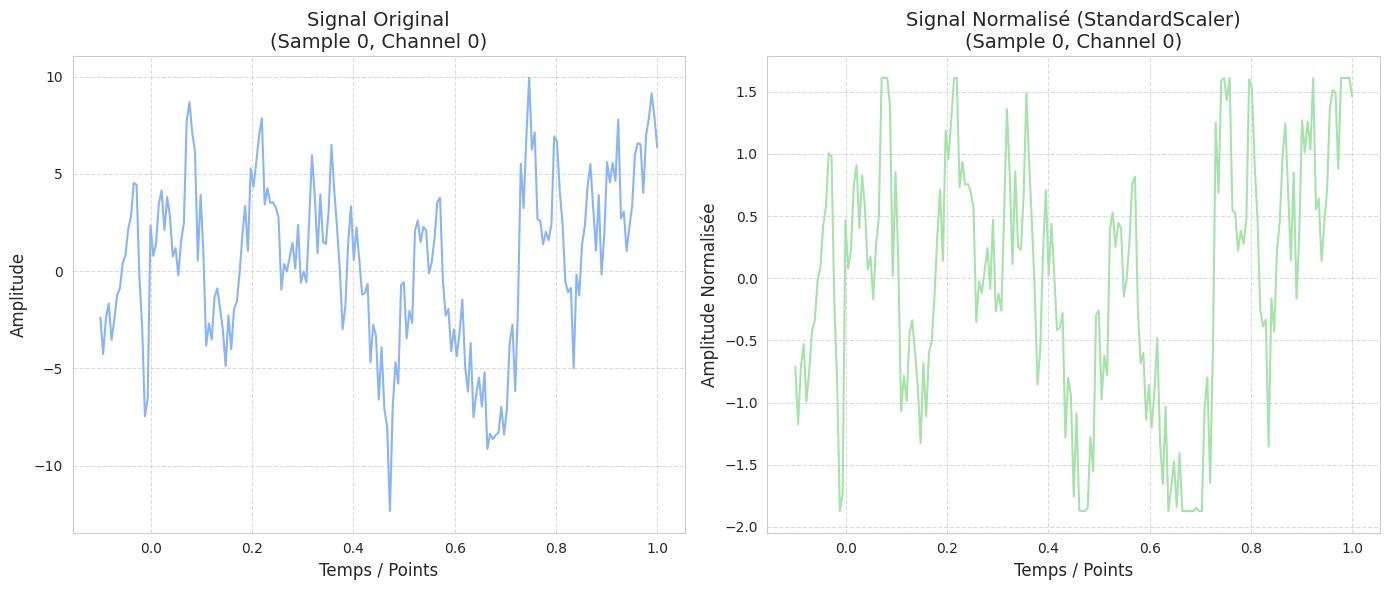

In [38]:
sample_to_plot = 0
channel_to_plot = 0
time = np.linspace(-0.1, 1, target_length)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1) 
plt.plot(time, x[sample_to_plot, channel_to_plot, :], color='#89B4FA')
plt.title(f'Signal Original\n(Sample {sample_to_plot}, Channel {channel_to_plot})', fontsize=14)
plt.xlabel('Temps / Points', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2) 
plt.plot(time, x_normalized[sample_to_plot, channel_to_plot, :], color='#A6E3AA') 
plt.title(f'Signal Normalisé (StandardScaler)\n(Sample {sample_to_plot}, Channel {channel_to_plot})', fontsize=14)
plt.xlabel('Temps / Points', fontsize=12)
plt.ylabel('Amplitude Normalisée', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

***Remarque:** Effet de la winso visibles*

In [39]:
# Frequency-domain features
x_freq = np.zeros((n_samples, n_channels, n_time_points // 2 + 1))
for i in range(n_samples):
    for ch in range(n_channels):
        fft_result = fft(x_normalized[i, ch, :])
        x_freq[i, ch, :] = np.abs(fft_result[:n_time_points // 2 + 1])

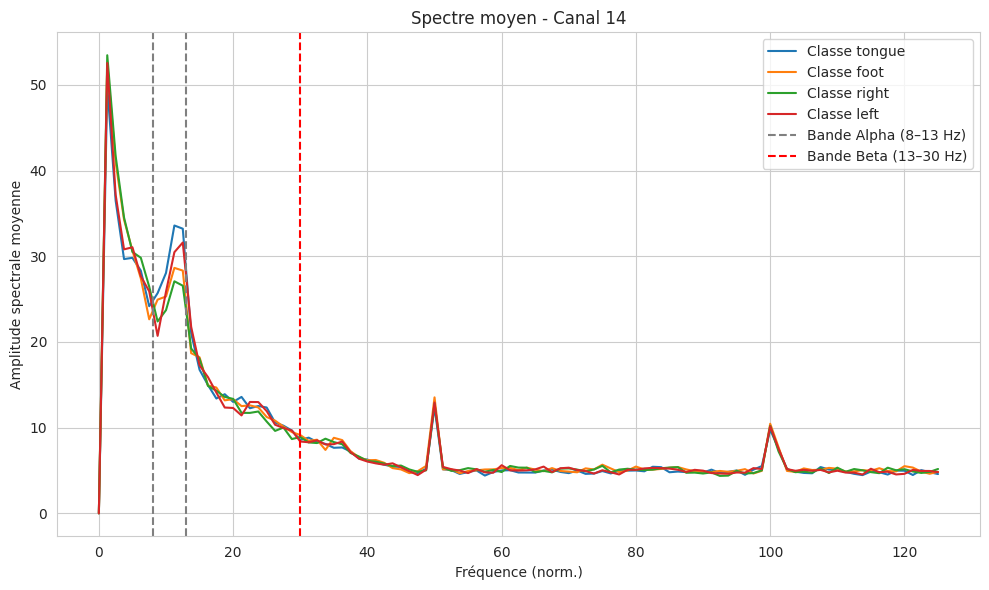

In [40]:
mean_spectra_per_class = []
for cls in labels:
    class_indices = np.where(y == cls)[0]
    class_mean_spectrum = x_freq[class_indices].mean(axis=0)  # Moyenne sur les échantillons
    mean_spectra_per_class.append(class_mean_spectrum)

channel_to_plot = 14
freqs = np.linspace(0, 250 / 2 , 101)
plt.figure(figsize=(10, 6))
for i, cls in enumerate(labels):
    plt.plot(freqs, mean_spectra_per_class[i][channel_to_plot], label=f"Classe {cls}")
plt.xlabel("Fréquence (norm.)")
plt.ylabel("Amplitude spectrale moyenne")
plt.title(f"Spectre moyen - Canal {channel_to_plot}")
plt.axvline(8, color='gray', linestyle='--', label='Bande Alpha (8–13 Hz)')
plt.axvline(13, color='gray', linestyle='--')
plt.axvline(30, color='red', linestyle='--', label='Bande Beta (13–30 Hz)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

***Remarque**: On observe un pic d'amplitude aux basses fréquences ; ce qui a de quoi dénoter de la partialité du pré-traitement, de par la persistance d'artéfacts (clignements d'yeux, etc.)*

## Augmentation des données
Afin d'assurer un apprentissage pertinent, dont le modèle résultant à la capacité de *généraliser*, il est nécessaire de disposer d'un jeu de donnée suffisammment conséquent. Subséquemment, on décide d'augmenter celui dont on dispose par la méthode du fenêtrage. En somme, on fait glisser une fenêtre de capture de dimensions données sur le signal dont on dispose afin de générer des sous-signaux en nombre.

***Remarque**: D'autres approches sont possibles ; on en donne un exemple plus loin.*

In [41]:
window_size = 50
stride = 10
x_windows, y_windows = [], []

for i in range(n_samples):
    data = x_normalized[i]
    freq_data = x_freq[i]
    num_windows = (n_time_points - window_size) // stride + 1

    for w in range(num_windows):
        start = w * stride
        end = start + window_size
        window = data[:, start:end]
        # On a réduit l'espace fréquentiel de moitié ; donc approxime linéairement la fenêtre fréquentielle
        freq_start = (start * (n_time_points // 2 + 1)) // n_time_points
        freq_end = (end * (n_time_points // 2 + 1)) // n_time_points
        freq_window = freq_data[:, freq_start:freq_end]
        # On controlle les dimensions à cause de l'approximation
        if freq_window.shape[1] < window_size:
            freq_window = np.pad(freq_window, ((0, 0), (0, window_size - freq_window.shape[1])), mode='constant')
        elif freq_window.shape[1] > window_size:
            freq_window = freq_window[:, :window_size]
        combined = np.stack([window, freq_window], axis=-1)
        x_windows.append(combined)
        y_windows.append(y[i])

x_windows = np.array(x_windows)
y_windows = np.array(y_windows)
print(f"Dimension de x_w : {x_windows.shape}")
print(f"Dimension de y_w : {y_windows.shape}")

Dimension de x_w : (10112, 22, 50, 2)
Dimension de y_w : (10112,)


In [50]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_windows)
y_categorical = tf.keras.utils.to_categorical(y_encoded)
print(f"Dimensions de y_one-hot-encoded : {y_categorical.shape}")

Dimensions de y_one-hot-encoded : (10112, 4)


## Formattage pré-entraînement

In [51]:
def data_building(x, y, type = "GRU"):
    """
        Arguments :
        x (samples, time_steps, channels, features)
        y (samples, 4)
        type in {"GRU", "CNN_LSTM", "GRUR"}
        Returns :
        X_train, X_test, y_train, y_test
    """
    
    if type in ["GRU", "GRUR", "CNN_LSTM"]:
        # Reshape to : (samples, time_steps, channels * features)
        x = x.transpose(0, 2, 1, 3)
        x = x.reshape(x.shape[0], x.shape[1], x.shape[2] * x.shape[3])
    
    return train_test_split(
        x, y, test_size=0.2, random_state=42, stratify=y
    )

X_train, X_test, y_train, y_test = data_building(x_windows,y_categorical)

# Visualizations

--- Raw EEG Signal Visualization (Sample) ---


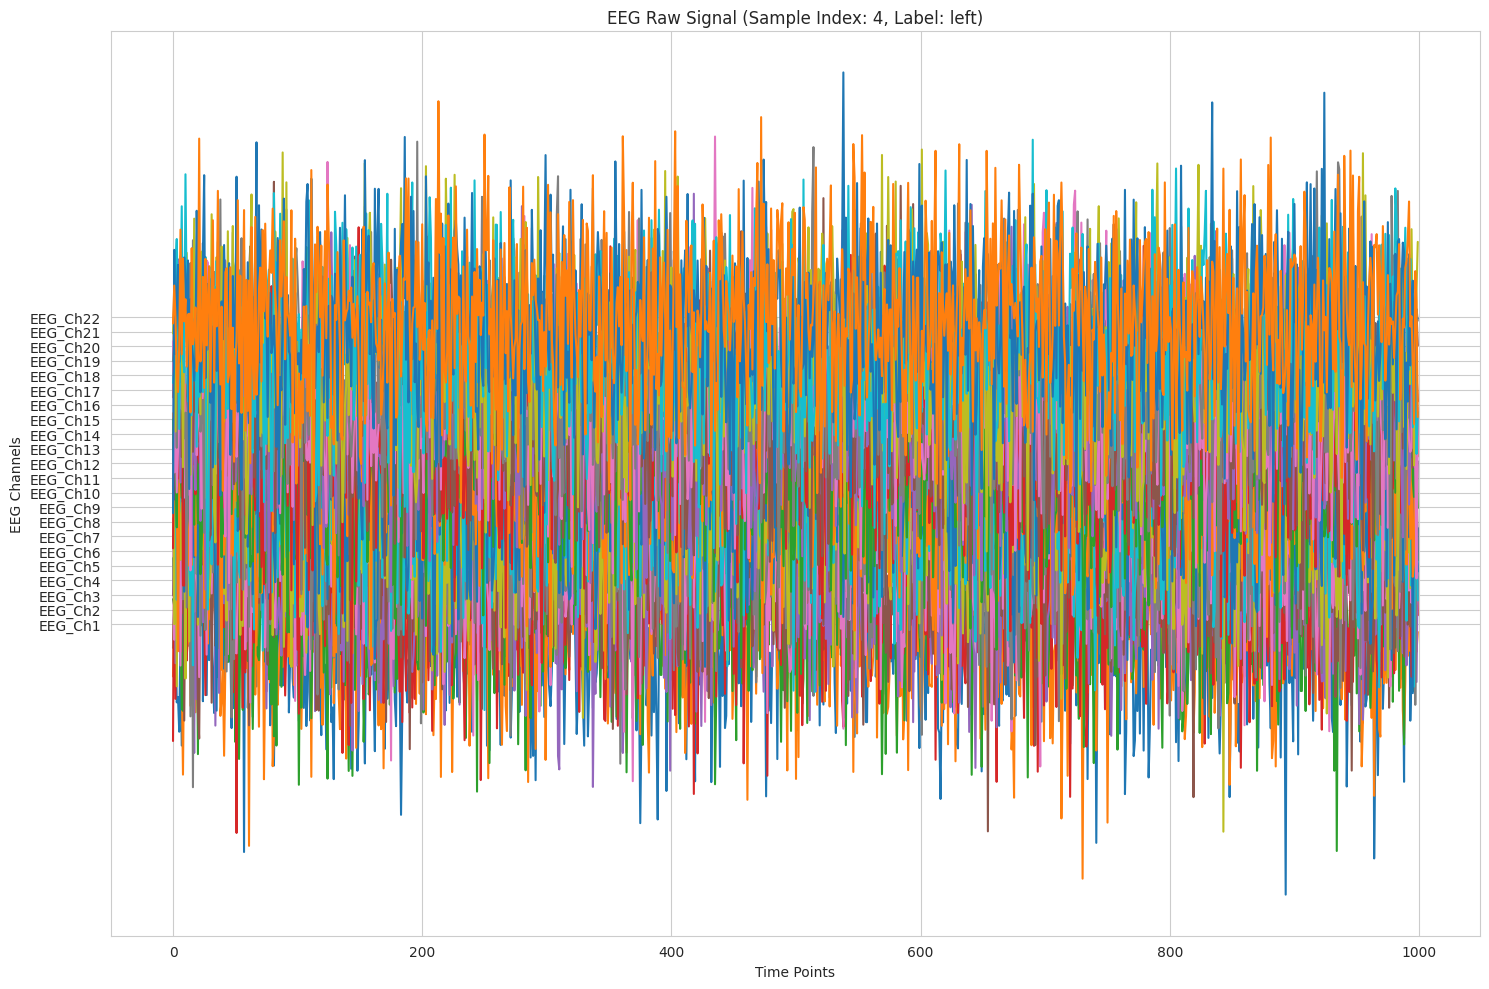


--- Raw vs. Normalized EEG Signal Comparison ---


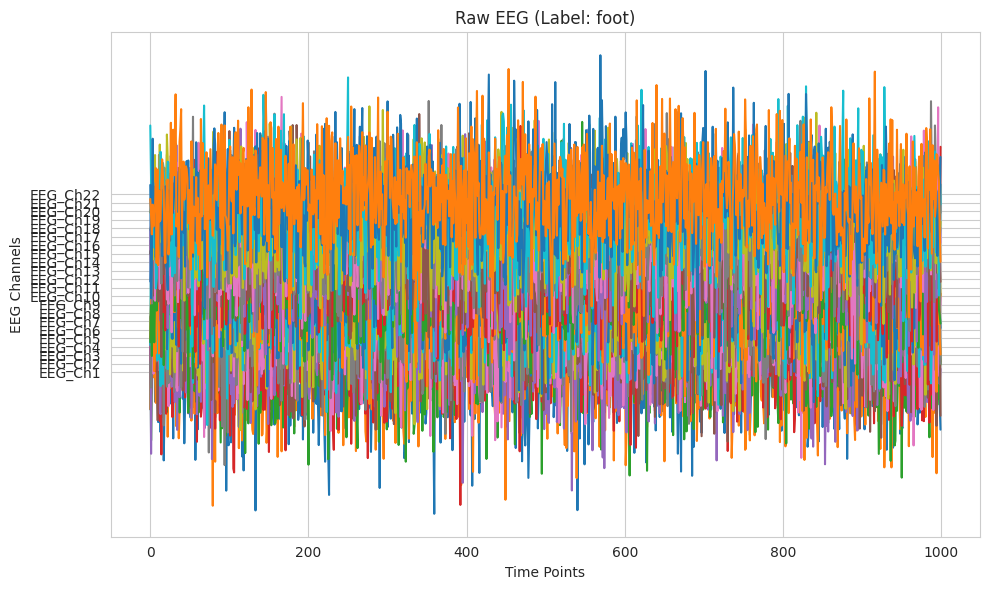

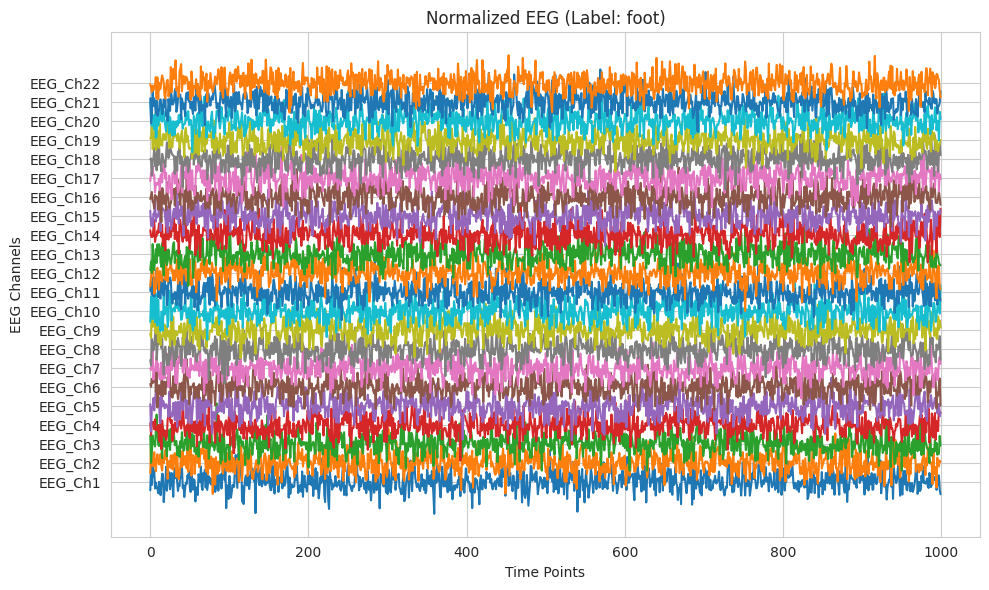


--- EEG Signal Frequency-Domain Visualization (FFT) ---


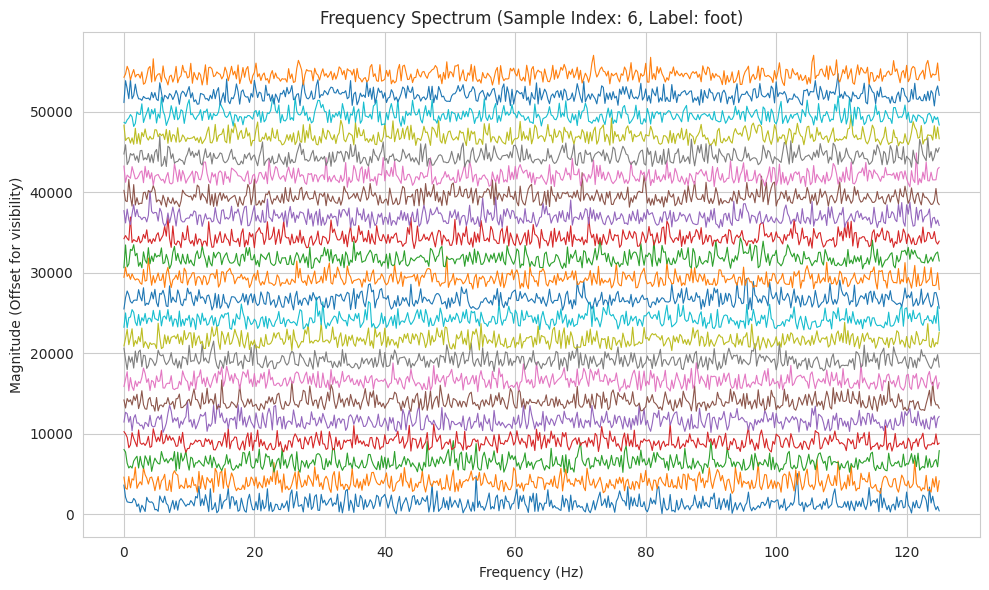


--- Spectrogram-like EEG Heatmap ---


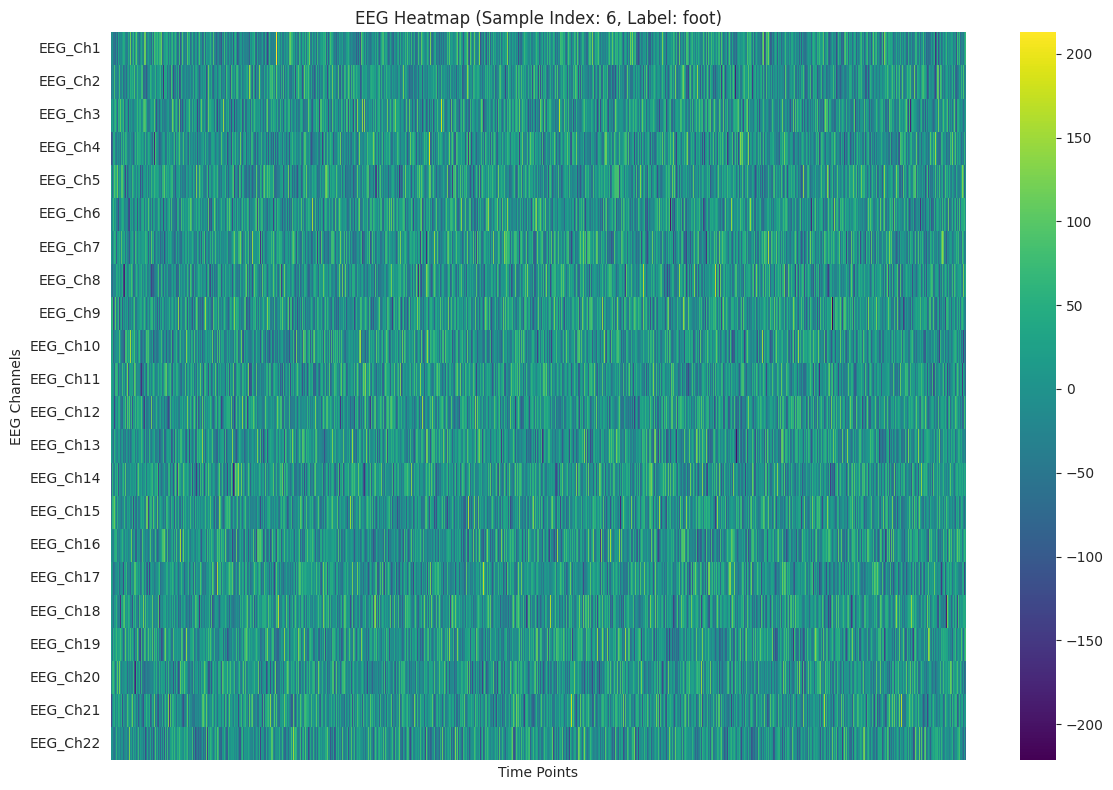


--- EEG Band Power Calculation ---


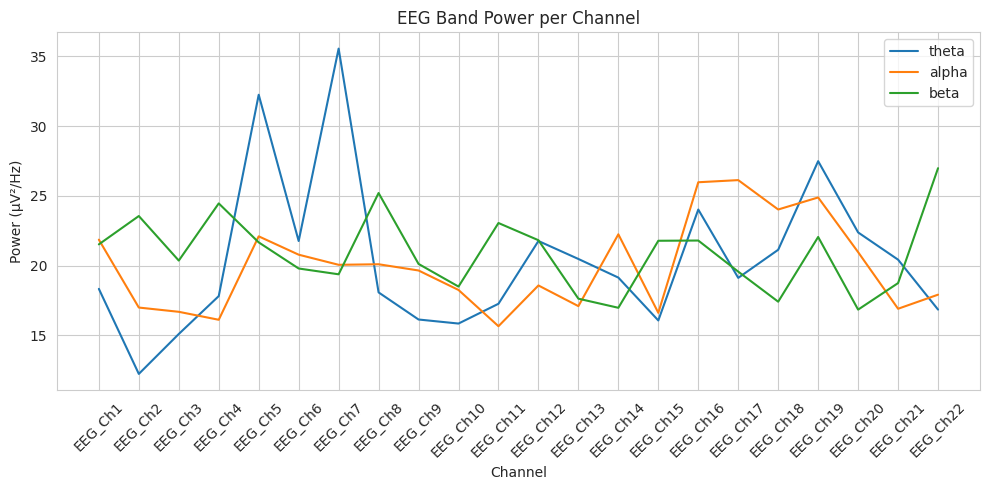


--- PCA and t-SNE Feature Visualization ---


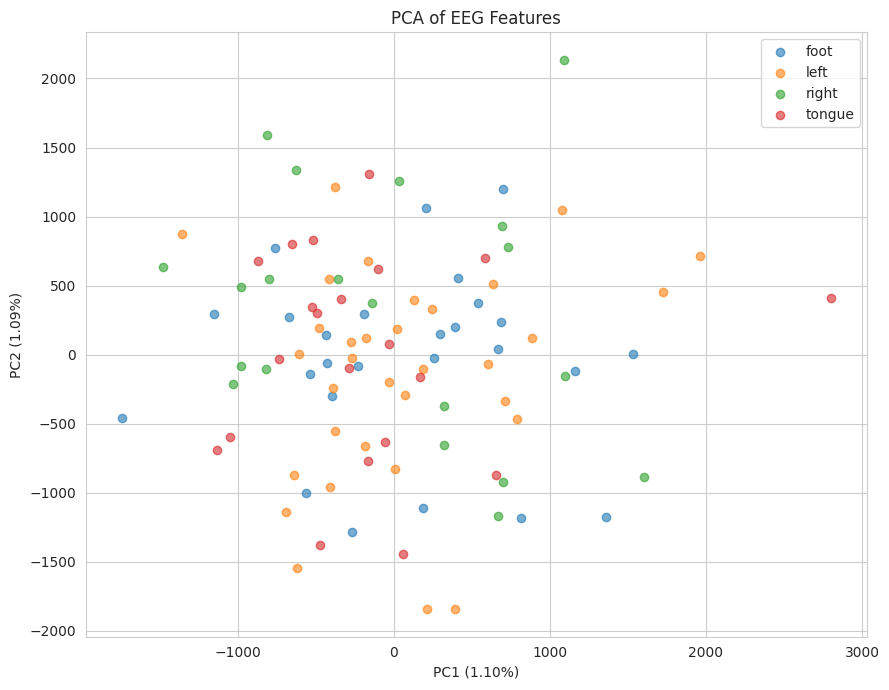

In [52]:
# --- Imports ---
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from scipy.fft import fft, rfftfreq
from scipy.signal import welch
import random

# --- Parameters for dummy data ---
n_samples = 100
n_channels = 22  # Standard for BCIC IV 2a
n_time_points = 1000  # Assuming 4 seconds at 250 Hz
sf = 250  # Sampling frequency

# Dummy raw EEG data (X)
X = np.random.randn(n_samples, n_channels, n_time_points) * 50

# Dummy labels (y)
labels = ['left', 'right', 'foot', 'tongue']
y = np.array(random.choices(labels, k=n_samples))

# EEG channel names
eeg_columns = [f'EEG_Ch{i+1}' for i in range(n_channels)]

# Normalize EEG data
scaler = StandardScaler()
X_reshaped = X.reshape(-1, n_time_points)
X_normalized_reshaped = scaler.fit_transform(X_reshaped)
X_normalized = X_normalized_reshaped.reshape(n_samples, n_channels, n_time_points)

# Frequency domain (FFT)
X_freq_real = np.abs(np.fft.rfft(X, axis=-1))

# Windowed features for PCA/t-SNE
X_windows = X  # Placeholder

# Label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = tf.keras.utils.to_categorical(y_encoded)

# --- Visualization: Raw EEG ---
print("--- Raw EEG Signal Visualization (Sample) ---")
left_indices = np.where(y == 'left')[0]
sample_idx = left_indices[0] if len(left_indices) > 0 else random.randint(0, n_samples - 1)
sample_data = X[sample_idx]

plt.figure(figsize=(15, 10))
for ch in range(sample_data.shape[0]):
    plt.plot(sample_data[ch] + ch * 10, label=f'Ch {eeg_columns[ch]}')
plt.yticks([ch * 10 for ch in range(sample_data.shape[0])], eeg_columns)
plt.title(f'EEG Raw Signal (Sample Index: {sample_idx}, Label: {y[sample_idx]})')
plt.xlabel("Time Points")
plt.ylabel("EEG Channels")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Comparison: Raw vs Normalized ---
print("\n--- Raw vs. Normalized EEG Signal Comparison ---")
target_class = 'foot'
class_indices = np.where(y == target_class)[0]
sample_idx = class_indices[0] if len(class_indices) > 0 else random.randint(0, n_samples - 1)
raw_sample = X[sample_idx]
norm_sample = X_normalized[sample_idx]
start_time, end_time = 0, raw_sample.shape[1]
raw_clip = raw_sample[:, start_time:end_time]
norm_clip = norm_sample[:, start_time:end_time]
time_points = np.arange(start_time, end_time)

# Raw EEG
plt.figure(figsize=(10, 6))
for ch in range(n_channels):
    plt.plot(time_points, raw_clip[ch] + ch * 10)
plt.yticks([ch * 10 for ch in range(n_channels)], eeg_columns)
plt.title(f'Raw EEG (Label: {target_class})')
plt.xlabel("Time Points")
plt.ylabel("EEG Channels")
plt.grid(True)
plt.tight_layout()
plt.show()

# Normalized EEG
plt.figure(figsize=(10, 6))
for ch in range(n_channels):
    plt.plot(time_points, norm_clip[ch] + ch * 2)
plt.yticks([ch * 2 for ch in range(n_channels)], eeg_columns)
plt.title(f'Normalized EEG (Label: {target_class})')
plt.xlabel("Time Points")
plt.ylabel("EEG Channels")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Frequency-Domain Visualization ---
print("\n--- EEG Signal Frequency-Domain Visualization (FFT) ---")
sample_freq = X_freq_real[sample_idx]
freqs = rfftfreq(n_time_points, d=1/sf)

plt.figure(figsize=(10, 6))
offset = np.max(sample_freq) * 0.5
for ch in range(n_channels):
    plt.plot(freqs, sample_freq[ch] + ch * offset, lw=0.8)
plt.title(f'Frequency Spectrum (Sample Index: {sample_idx}, Label: {y[sample_idx]})')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (Offset for visibility)")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Heatmap ---
print("\n--- Spectrogram-like EEG Heatmap ---")
plt.figure(figsize=(12, 8))
sns.heatmap(sample_data, cmap='viridis', yticklabels=eeg_columns, xticklabels=False)
plt.title(f'EEG Heatmap (Sample Index: {sample_idx}, Label: {y[sample_idx]})')
plt.xlabel("Time Points")
plt.ylabel("EEG Channels")
plt.tight_layout()
plt.show()

# --- Band Power ---
print("\n--- EEG Band Power Calculation ---")
def bandpower(data, sf, band, window_sec=None):
    low, high = band
    nperseg = int(window_sec * sf) if window_sec else None
    freqs, psd = welch(data, sf, nperseg=nperseg)
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    return np.mean(psd[idx_band]) if np.any(idx_band) else 0.0

bands = {'theta': (4, 7), 'alpha': (8, 13), 'beta': (14, 30)}
band_powers = {band: [] for band in bands}

for ch in range(n_channels):
    signal = sample_data[ch]
    for band, band_range in bands.items():
        band_powers[band].append(bandpower(signal, sf, band_range, window_sec=2))

plt.figure(figsize=(10, 5))
for band in bands:
    plt.plot(band_powers[band], label=band)
plt.xticks(np.arange(n_channels), eeg_columns, rotation=45)
plt.title("EEG Band Power per Channel")
plt.xlabel("Channel")
plt.ylabel("Power (μV²/Hz)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- PCA Visualization ---
print("\n--- PCA and t-SNE Feature Visualization ---")
X_flat = X_windows.reshape(n_samples, -1)
y_labels = np.argmax(y_categorical, axis=1)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_flat)

plt.figure(figsize=(9, 7))
for i in np.unique(y_labels):
    label = label_encoder.classes_[i] if i < len(label_encoder.classes_) else f'Class {i}'
    plt.scatter(X_pca[y_labels == i, 0], X_pca[y_labels == i, 1], label=label, alpha=0.6)
plt.title("PCA of EEG Features")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# *Model Creation*

In [53]:
# Define input shape from X_train
channels = X.shape[1]
timesteps = X_train.shape[1]       # 50
features = X_train.shape[2]        # 22 * 2 = 44
num_classes = y_train.shape[1]     # 4
MODEL_TYPE = "GRU"

In [54]:
def CNN_LSTM(input_shape, num_classes, dropoutRate=0.3, l2_reg = 0.002):
    input1 = Input(shape=input_shape)

    x = Conv1D(32, kernel_size=3, padding='same', activation='elu', kernel_regularizer=l2(l2_reg))(input1)
    x = BatchNormalization()(x)
    x = Dropout(dropoutRate)(x)

    x = Conv1D(64, kernel_size=3, padding='same', activation='elu', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(dropoutRate)(x)

    x = LSTM(128, return_sequences=True, dropout=dropoutRate)(x)
    x = LSTM(64, dropout=dropoutRate)(x)

    x = Dense(64, activation='elu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropoutRate)(x)
    x = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=input1, outputs=x)

In [55]:
def GRU_Flatten_Model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    gru_out = GRU(256, return_sequences=True)(inputs)
    flatten_out = Flatten()(gru_out)
    outputs = Dense(num_classes, activation='softmax')(flatten_out)
    return Model(inputs=inputs, outputs=outputs)

In [58]:
match MODEL_TYPE:
    case "GRU":
        model = GRU_Flatten_Model(input_shape=(timesteps, features), num_classes=num_classes)
    case "GRUR":
        model = GRU_Regularized_Model(input_shape=(timesteps, features),num_classes=num_classes,dropout_rate=0.2, l2_reg=0.002)
    case "CNN_LSTM":
        model = CNN_LSTM(input_shape=(timesteps, features), num_classes=num_classes, dropoutRate=0.3, l2_reg = 0.002)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
          loss='categorical_crossentropy',
          metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 50, 44)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 50, 256)             │         231,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │          51,204 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 283,140 (1.08 MB)

 Trainable params: 283,140 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

# **Train Model**

In [59]:
early_stopping = EarlyStopping(monitor='val_accuracy', 
                               patience=6, 
                               restore_best_weights=True, 
                               mode='max')
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', 
                                 factor=0.5, 
                                 patience=5, 
                                 min_lr=1e-6)

history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=100,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, lr_scheduler],
                    verbose=1)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch 1/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 28s 95ms/step - accuracy: 0.2580 - loss: 1.5272 - val_accuracy: 0.3010 - val_loss: 1.4361 - learning_rate: 5.0000e-04
Epoch 2/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 23s 92ms/step - accuracy: 0.3799 - loss: 1.3229 - val_accuracy: 0.2951 - val_loss: 1.4397 - learning_rate: 5.0000e-04
Epoch 3/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 24s 93ms/step - accuracy: 0.4475 - loss: 1.2288 - val_accuracy: 0.3426 - val_loss: 1.4159 - learning_rate: 5.0000e-04
Epoch 4/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - accuracy: 0.5100 - loss: 1.1308 - val_accuracy: 0.3643 - val_loss: 1.3725 - learning_rate: 5.0000e-04
Epoch 5/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 0.5767 - loss: 1.0151 - val_accuracy: 0.4320 - val_loss: 1.3106 - learning_rate: 5.0000e-04
Epoch 6/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 23s 92ms/step - accuracy: 0.6722 - loss: 0.8472 - val_accuracy: 0.4800 - val_loss: 1.2183 - learning_rate: 5.0000e-04
Epoch 7/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 23s 9

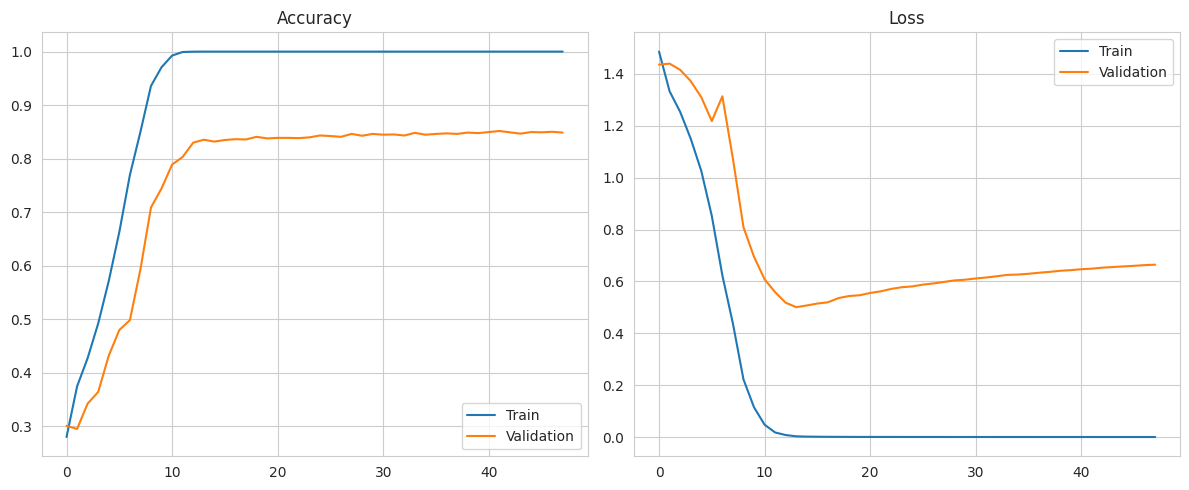

In [60]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("training_plot.png")
plt.show()

64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step


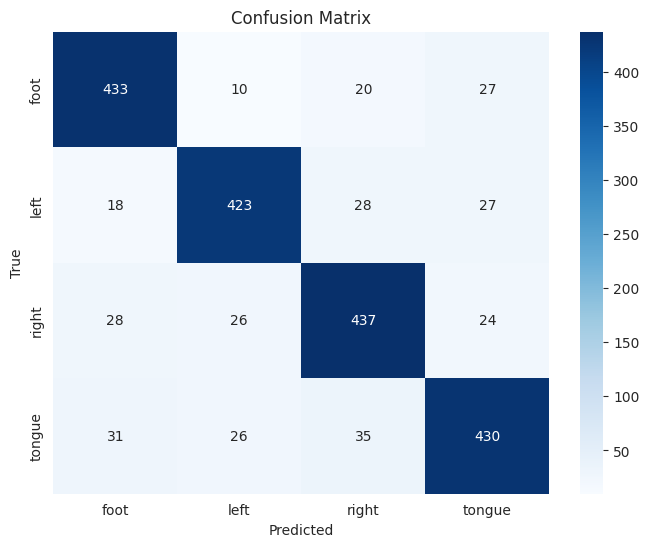

Classification Report:
              precision    recall  f1-score   support

        foot       0.85      0.88      0.87       490
        left       0.87      0.85      0.86       496
       right       0.84      0.85      0.84       515
      tongue       0.85      0.82      0.83       522

    accuracy                           0.85      2023
   macro avg       0.85      0.85      0.85      2023
weighted avg       0.85      0.85      0.85      2023



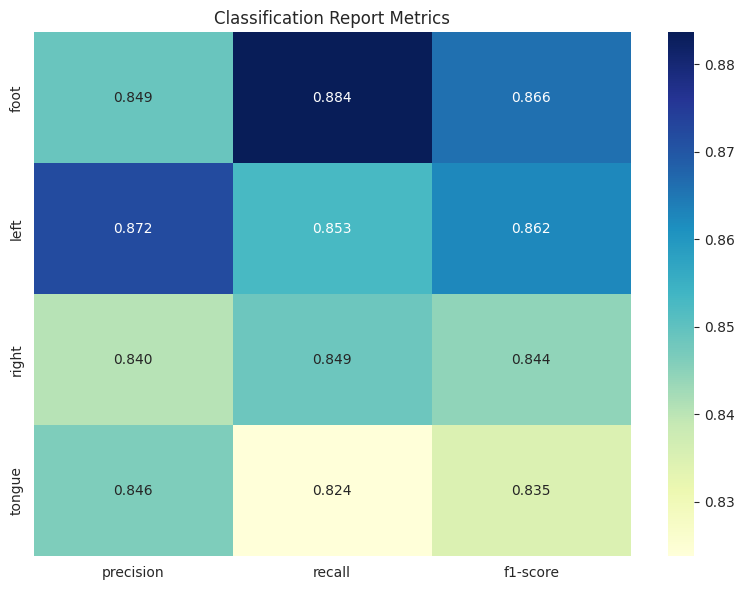

In [61]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
labels = label_encoder.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))


report = classification_report(y_true, y_pred, target_names=labels,output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-3, :-1].astype(float), 
            annot=True, cmap='YlGnBu', fmt='.3f')
plt.title('Classification Report Metrics')
plt.tight_layout()
plt.savefig('classification_report_heatmap.png', dpi=300)